In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

### 8.3 PCA

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [5]:
X2D_using_svd = X2D

#### 8.3.4 PCA using scikit-learn

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [7]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [8]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [9]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [10]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

In [11]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

#### 8.3.6

In [12]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


In [13]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [15]:
d

154

In [16]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [17]:
np.sum(pca.explained_variance_ratio_)

0.9504463030200188

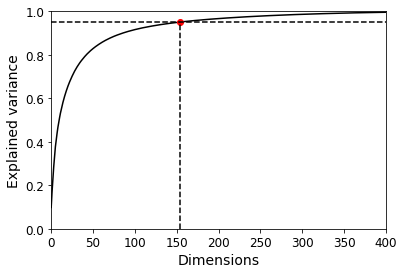

In [18]:
plt.figure(figsize=(6,4))
plt.plot((np.arange(len(cumsum))), cumsum, 'k-')
plt.plot(d, np.sum(pca.explained_variance_ratio_), 'ro')
plt.plot([d, d], [0, np.sum(pca.explained_variance_ratio_)], 'k--')
plt.plot([0, 400], [np.sum(pca.explained_variance_ratio_), np.sum(pca.explained_variance_ratio_)], 'k--')
plt.xlabel("Dimensions", fontsize=14)
plt.ylabel("Explained variance", fontsize=14)
plt.axis([0, 400, 0, 1])
plt.show()

#### 8.3.7 圧縮のためのPCA

In [19]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [20]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5,1,'Compressed')

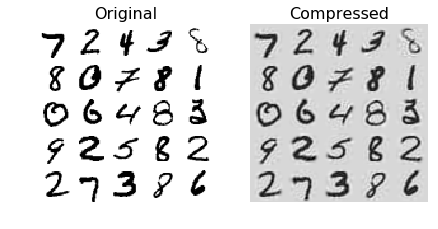

In [21]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

In [22]:
X_reduced_pca = X_reduced

#### 8.3.8 追加学習型PCA

In [23]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

In [24]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

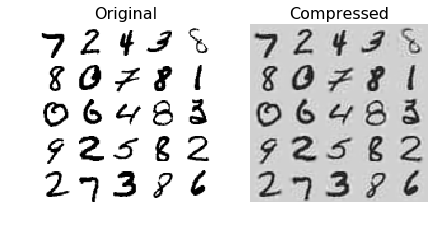

In [25]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.title("Compressed", fontsize=16)
plt.tight_layout

In [26]:
X_reduced_inc_pca = X_reduced

In [27]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

### 8.4 カーネルPCA

In [28]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [29]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel = "rbf", gamma = 0.04)
X_reduced = rbf_pca.fit_transform(X)

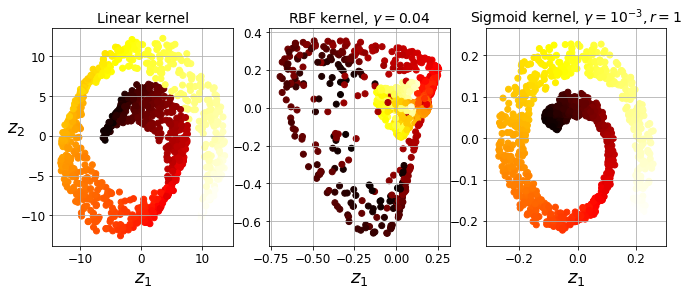

In [30]:
lin_pca = KernelPCA(n_components=2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0443, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
        
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)
    
plt.show()

#### 8.4.1 Selection of kernel and tuning parameters

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression(solver="liblinear")),
])

param_grid = [ {"kpca__gamma": np.linspace(0.03, 0.05, 10), "kpca__kernel": ["rbf", "sigmoid"]} ]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=None,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRe...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kpca__gamma': array([0.03   , 0.03222, 0.03444, 0.03667, 0.03889, 0.04111, 0.04333,
       0.04556, 0.04778, 0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [32]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [33]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04333, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [34]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.79434368784026

### 8.5 LLE

In [35]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [36]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

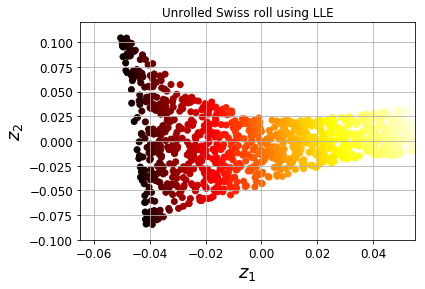

In [37]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.title("Unrolled Swiss roll using LLE")
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

### 8.6 Other techniques

In [38]:
from sklearn.manifold import MDS, Isomap, TSNE

In [39]:
mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [40]:
isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [41]:
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

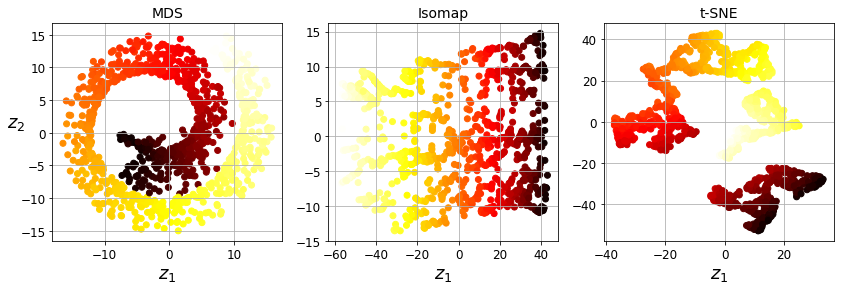

In [42]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(14,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles, 
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.title(title, fontsize=14)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)
    
plt.show()

#### LDA

In [43]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [44]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


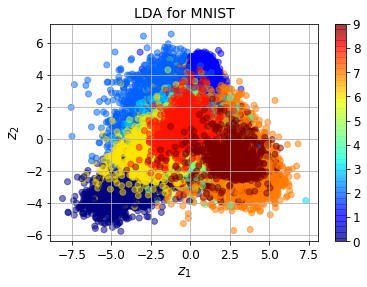

In [45]:
plt.scatter(X_reduced_lda[: ,0], X_reduced_lda[:, 1], c=y_mnist, cmap=plt.cm.jet, alpha=0.5)
plt.title("LDA for MNIST", fontsize=14)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.grid(True)
plt.colorbar()

plt.show()

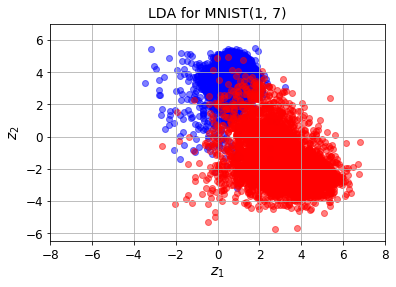

In [46]:
# plt.scatter(X_reduced_lda[: ,0], X_reduced_lda[:, 1], c=y_mnist, cmap=plt.cm.jet, alpha=0.5)
plt.scatter(X_reduced_lda[: ,0][y_mnist==1], X_reduced_lda[:, 1][y_mnist==1], c='b', alpha=0.5)
plt.scatter(X_reduced_lda[: ,0][y_mnist==7], X_reduced_lda[:, 1][y_mnist==7], c='r', alpha=0.5)
plt.title("LDA for MNIST(1, 7)", fontsize=14)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.grid(True)
plt.axis([-8, 8, -6.5, 7])

plt.show()

In [47]:
tsne = TSNE(n_components=2, random_state=42)
X = X_mnist[:10000]
X_reduced_tsne = tsne.fit_transform(X)

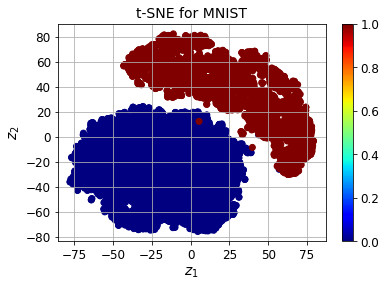

In [51]:
plt.scatter(X_reduced_tsne[: ,0], X_reduced_tsne[:, 1], c=y_mnist[:10000], cmap=plt.cm.jet)
plt.title("t-SNE for MNIST", fontsize=14)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.grid(True)
plt.colorbar()

plt.show()

### 8.7 Exercises

#### 9

In [57]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

In [59]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)

In [60]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

print("training time: {}".format(t1-t0))

training time: 5.265186071395874


In [61]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9455

In [63]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [65]:
rnd_clf2 = RandomForestClassifier(n_estimators=10, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

print("training time: {}".format(t1-t0))

training time: 10.487929105758667


In [66]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.8908

In [68]:
# LogisticRegression using PCA
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [69]:
print("training time: {}".format(t1-t0))

training time: 28.43481183052063


In [70]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

In [71]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

print("training time: {}".format(t1-t0))

y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

training time: 8.322911977767944


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.9201

#### 10

In [84]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]


In [85]:
X = mnist["data"][idx]
y = mnist["target"][idx]

In [86]:
from sklearn.manifold import TSNE

In [87]:
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

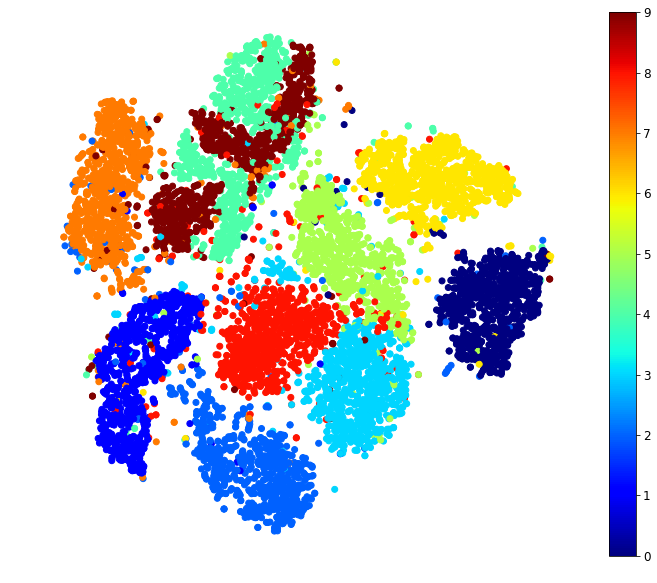

In [88]:
plt.figure(figsize=(12, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='jet')
plt.axis('off')
plt.colorbar()

plt.show()

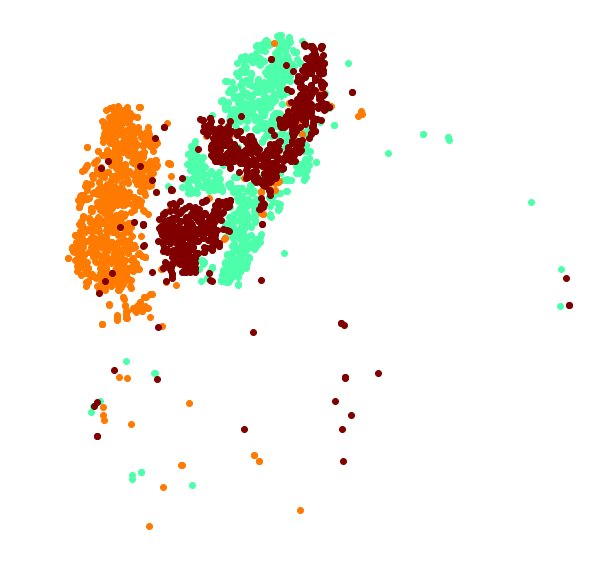

In [92]:
plt.figure(figsize=(10, 10))
cmap = mpl.cm.get_cmap('jet')
for digit in (4, 7, 9):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit/9)])
plt.axis('off')

plt.show()

In [101]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13,10)):
    X_normalized = MinMaxScaler().fit_transform(X)
    neighbors = np.array([[10., 10.]])
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap('jet')
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis('off')
    ax = plt.gcf().gca()
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                        color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

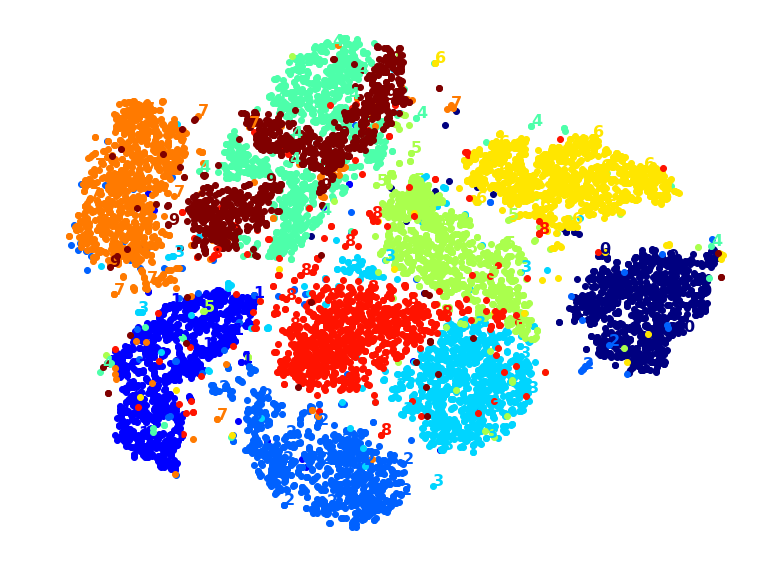

In [102]:
plot_digits(X_reduced, y)

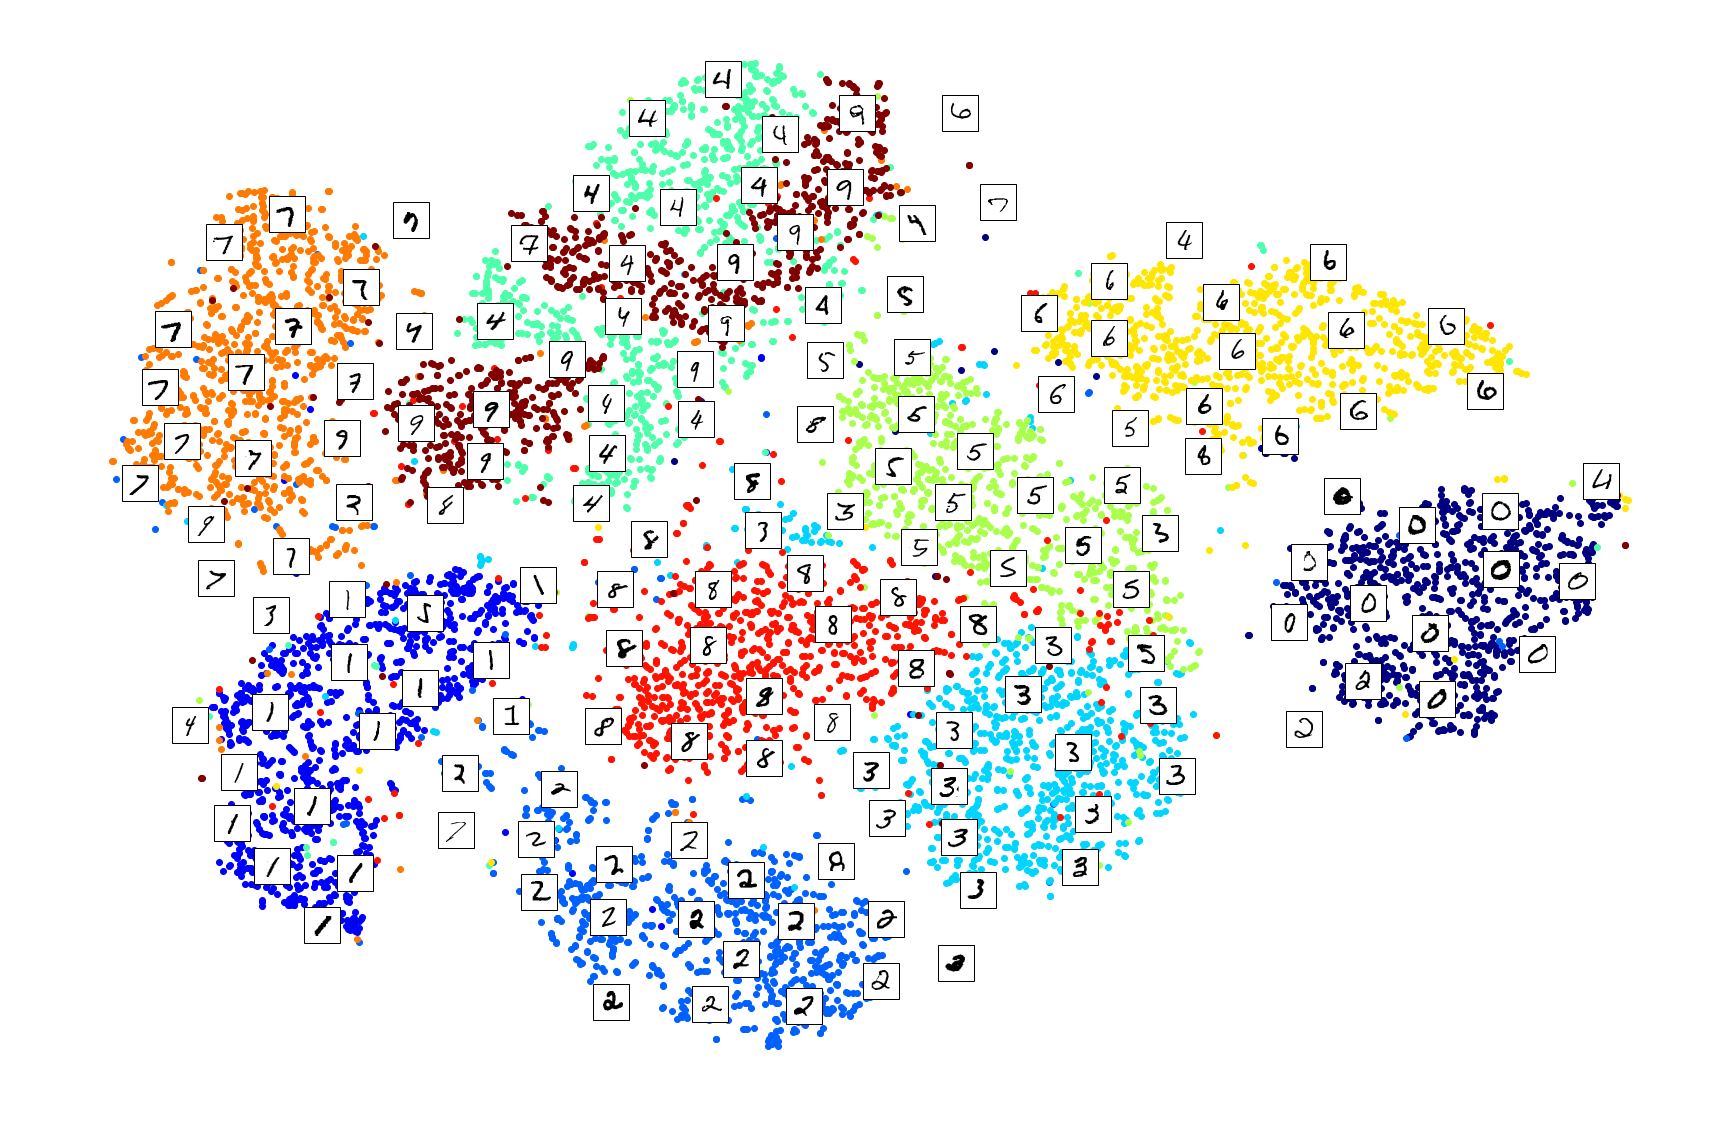

In [103]:
plot_digits(X_reduced, y, images=X, figsize=(30, 20))

In [104]:
idx = (y == 4) | (y == 7) | (y == 9) 
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

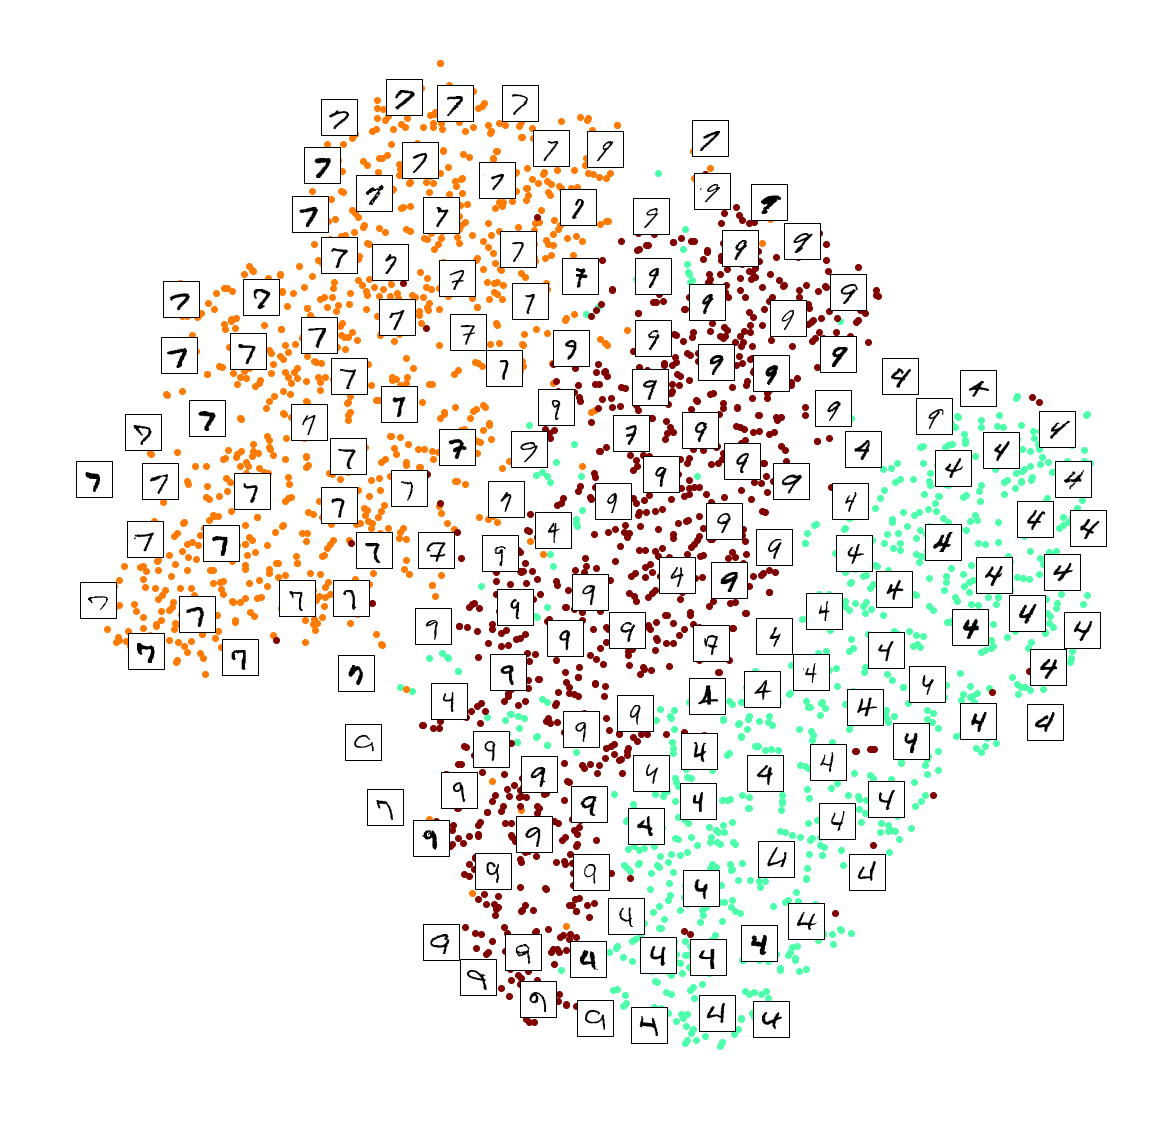

In [105]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(20, 20))

In [106]:
from sklearn.decomposition import PCA
import time

training time: 0.5s


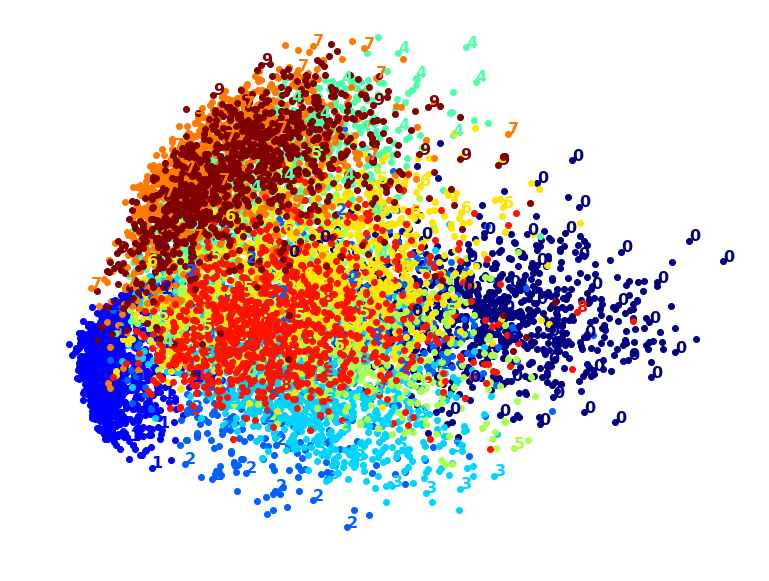

In [108]:
t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("training time: {:.1f}s".format(t1-t0))
plot_digits(X_pca_reduced, y)
plt.show()

training time: 159.0s


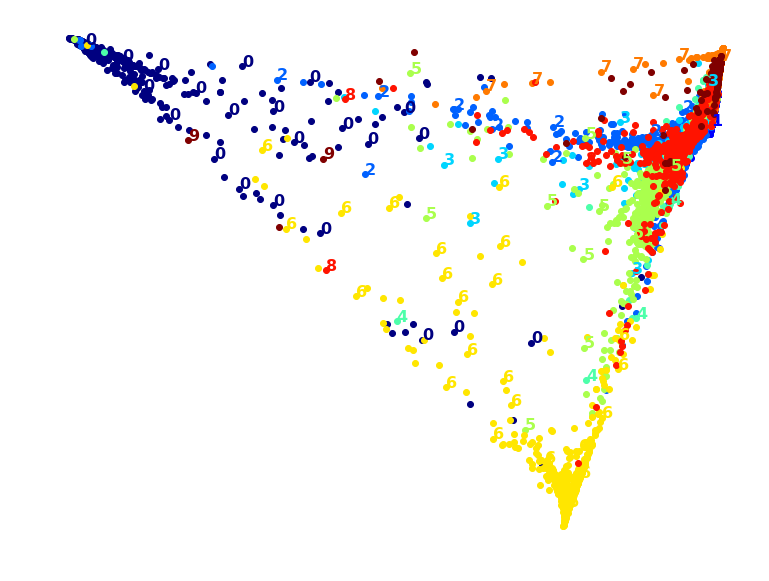

In [109]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("training time: {:.1f}s".format(t1-t0))
plot_digits(X_lle_reduced, y)
plt.show()

PCA+LLE training time: 55.9s


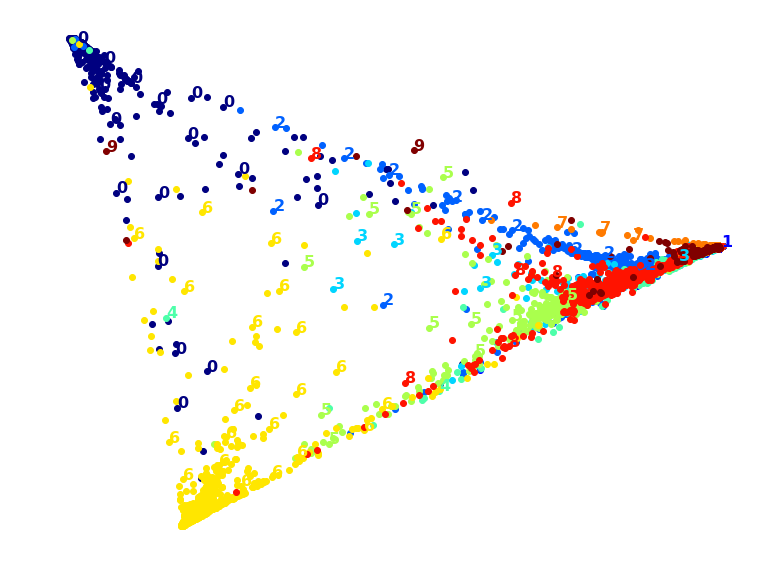

In [111]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42))
])

t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE training time: {:.1f}s".format(t1-t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


training time: 3.4s


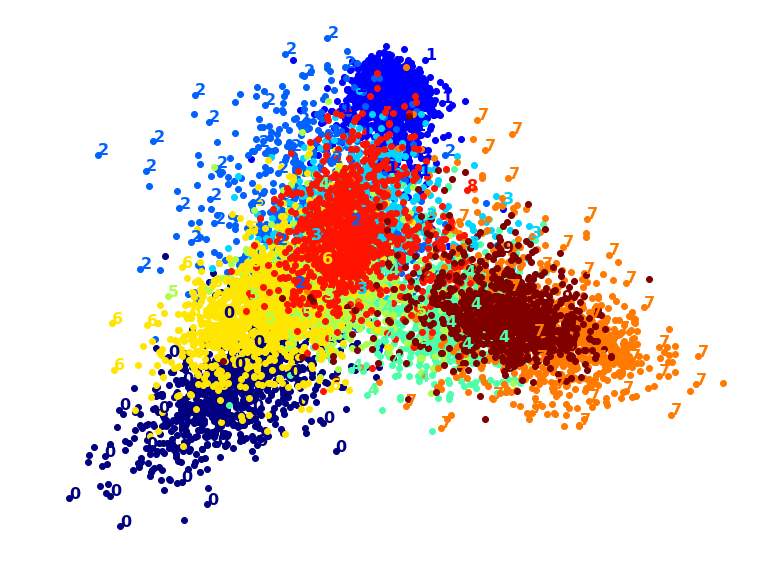

In [113]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("training time: {:.1f}s".format(t1-t0))
plot_digits(X_lda_reduced, y)
plt.show()

PCA+LDA training time: 2.5s


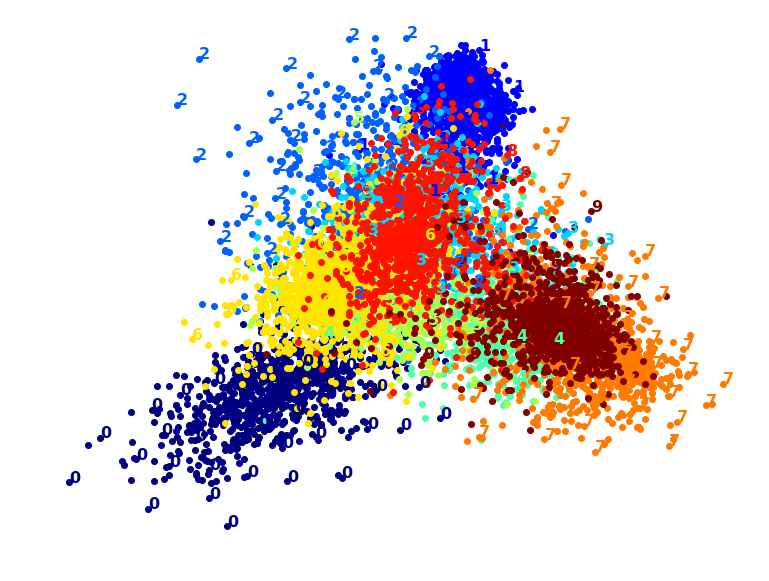

In [115]:
pca_lda = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lda", LinearDiscriminantAnalysis(n_components=2))
])

t0 = time.time()
X_pca_lda_reduced = pca_lda.fit_transform(X, y)
t1 = time.time()
print("PCA+LDA training time: {:.1f}s".format(t1-t0))
plot_digits(X_pca_lda_reduced, y)
plt.show()

PCA+t-SNE training time: 152.1


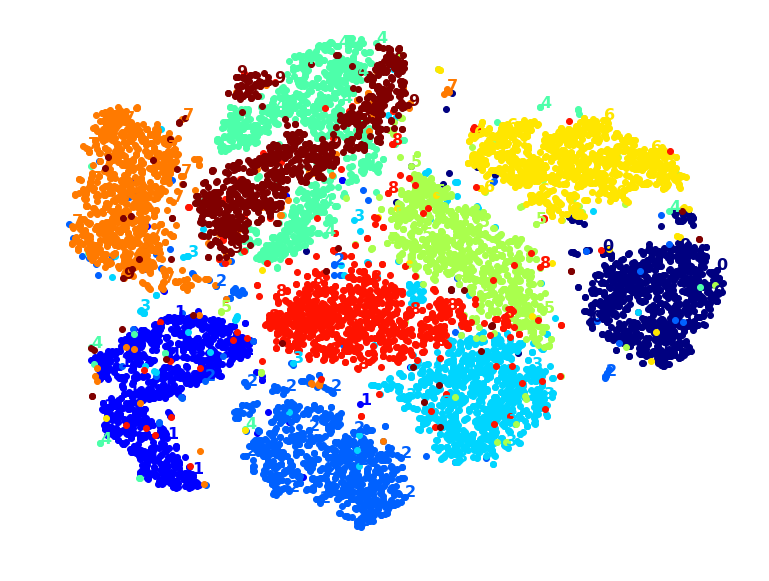

In [116]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("t-SNE", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE training time: {:.1f}".format(t1-t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()

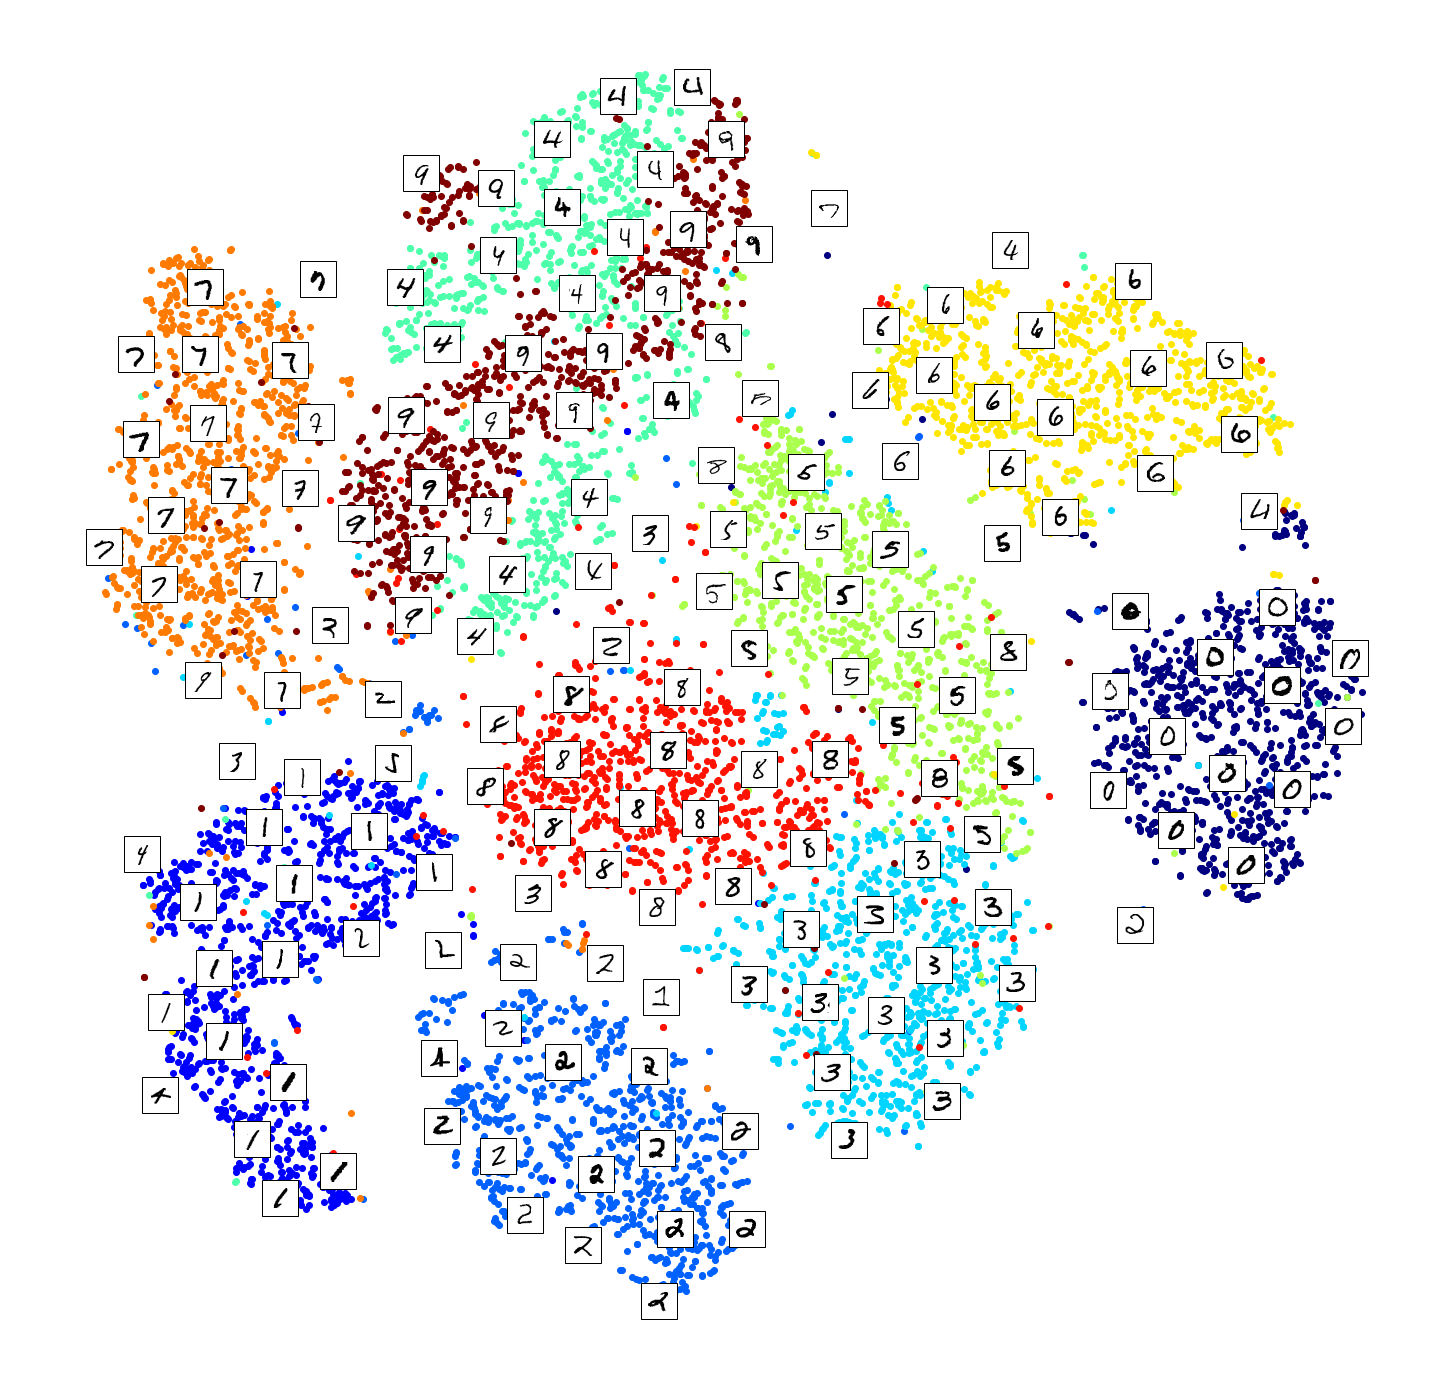

In [118]:
plot_digits(X_pca_tsne_reduced, y, images=X, figsize=(25,25))